In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# IMPORTING THE IMAGES AND MAKING A SAMPLE DATASET

In [3]:
#importing the main folder and excel file
data_dir = '/content/drive/MyDrive/Eye/'
excel = pd.read_csv(data_dir+'data_information (1).csv')
#dividing it into 3 folders
cnv=excel[(excel['Class']=='CNV') & (excel['Label']=='CNV')]
normal=excel[(excel['Class']=='CNV') & (excel['Label']=='NORMAL')]
drusen = excel[(excel['Class']=='DRUSEN') & (excel['Label']=='DRUSEN')]
#making a sampled dataset which contain 300 images
cnv_subset = cnv.sample(n=400,random_state=42)
normal_subset = normal.sample(n=400,random_state=42)
drusen_subset = drusen.sample(n=400,random_state=42)
sampled_data = pd.concat([cnv_subset, normal_subset, drusen_subset], ignore_index=True)
drusen = pd.concat([normal_subset, drusen_subset], ignore_index=True)
cnv=pd.concat([cnv_subset, normal_subset], ignore_index=True)
both=pd.concat([cnv_subset, drusen_subset], ignore_index=True)

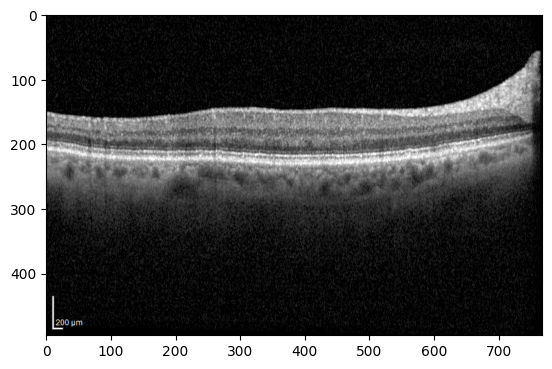

In [4]:
import cv2
images=[]
for i in both['Directory']:
  img = cv2.imread(data_dir+i)
  images.append(img)
plt.imshow(img, cmap='gray')

In [5]:
from skimage import exposure
from skimage.filters import threshold_otsu
from skimage.feature import hog
def extract_hog_features(images, do_otsu=True):
    hog_features = []
    hog_images = []
    thresholded_images = []
    for gray_image in images:
        if do_otsu:
            threshold_value = threshold_otsu(gray_image)
            threshold_image = gray_image > threshold_value
            thresholded_images.append(threshold_image)

        # Calculate HOG features
        features, hog_image = hog(gray_image if not do_otsu else threshold_image,
                                   visualize=True, multichannel=False,
                                   pixels_per_cell=(8, 8), cells_per_block=(2, 2))

        # Enhance the contrast of the HOG image
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        hog_images.append(hog_image_rescaled)
        hog_features.append(features)

    return np.array(hog_features), hog_images, thresholded_images

# Extract HOG features
images = [cv2.imread(os.path.join(data_dir, img_path)) for img_path in both['Directory']]
gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

hog_features, hog_images, _ = extract_hog_features(gray_images)

# Define X as the HOG features
X = hog_features

# Encode the target vector
y = both['Label']
y_encoded = y.map({'CNV': 0, 'DRUSEN': 1})

<ipython-input-5-288580e14146>:15: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, hog_image = hog(gray_image if not do_otsu else threshold_image,


In [6]:
  # Print the shape of the HOG features
print("HOG features shape:", hog_features.shape)

HOG features shape: (800, 208620)


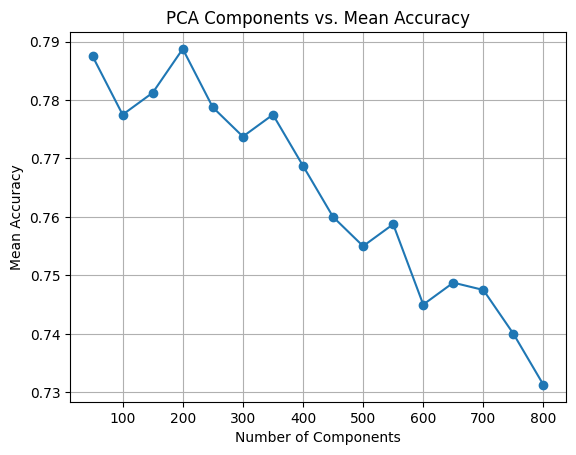

In [7]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt

# Define the range of number of components to test
components_to_test = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]  # Add more numbers as needed

# Lists to store number of components and mean accuracies
n_components_list = []
mean_accuracy_list = []

# Define your SVM classifier
svm_classifier = SVC(kernel="rbf")

# Train your classifier using k-fold cross-validation for each number of components
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for n_components in components_to_test:
    # Perform PCA on the HOG features with the specified number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(hog_features)

    # Perform k-fold cross-validation
    cv_scores = cross_val_score(svm_classifier, X_pca, y_encoded, cv=kfold)

    # Calculate the mean accuracy
    mean_accuracy = cv_scores.mean()

    # Append the number of components and mean accuracy to the lists
    n_components_list.append(n_components)
    mean_accuracy_list.append(mean_accuracy)

# Plot the number of components against the mean accuracy
plt.plot(n_components_list, mean_accuracy_list, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Mean Accuracy')
plt.title('PCA Components vs. Mean Accuracy')
plt.grid(True)
plt.show()


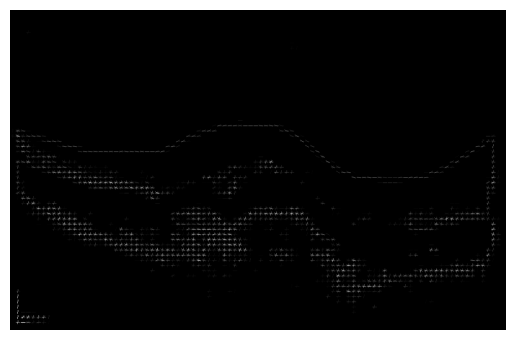

In [ ]:
import matplotlib.pyplot as plt

# Display one of the HOG images
plt.imshow(hog_images[40], cmap='gray')
plt.axis('off')
plt.show()


In [8]:
from sklearn.decomposition import PCA

# Perform PCA on the HOG features
pca = PCA(n_components=200)  # Specify the number of components you want to keep
X_pca = pca.fit_transform(X)

# Print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Print the cumulative explained variance ratio
print("Cumulative explained variance ratio:", np.cumsum(pca.explained_variance_ratio_))

Explained variance ratio: [0.09986131 0.05113025 0.02216438 0.02146261 0.01421004 0.01076267
 0.01021314 0.00863496 0.00816123 0.0068975  0.00676987 0.00664255
 0.00572352 0.00535355 0.00510095 0.00504609 0.00487901 0.00461152
 0.00455342 0.0042564  0.00406355 0.004042   0.00391672 0.00371655
 0.0036638  0.00356436 0.00354186 0.00335003 0.00326522 0.00320696
 0.00312079 0.00309524 0.00300174 0.00297907 0.00290475 0.0028431
 0.0028173  0.00277334 0.00273048 0.00262516 0.00258337 0.00255138
 0.0025324  0.0024507  0.00244308 0.00239755 0.00238285 0.00234429
 0.00232852 0.00229901 0.00228177 0.00223334 0.00221227 0.00217122
 0.00215462 0.0021382  0.00211313 0.00210793 0.00208606 0.00207044
 0.00202239 0.00202096 0.00201789 0.00198927 0.00198124 0.00194544
 0.00193429 0.00192683 0.00192084 0.00191075 0.00189412 0.00188337
 0.00187888 0.00186713 0.00184879 0.00183818 0.00182813 0.00180415
 0.00180002 0.00178569 0.00177836 0.00176603 0.00175857 0.00175058
 0.0017364  0.00172532 0.00171542 0.0

In [16]:
# Define X as the HOG features
X =X_pca

# Encode the target vector
y = both['Label']
y_encoded = y.map({'CNV': 0, 'DRUSEN': 1})

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="linear")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.6875  0.61875 0.7625  0.73125 0.7    ]
Mean Accuracy: 0.7


In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="rbf")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.83125 0.71875 0.8375  0.75625 0.79375]
Mean Accuracy: 0.7875


In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
# Define your SVM classifier
svm_classifier = SVC(kernel="sigmoid")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.73125 0.58125 0.73125 0.675   0.675  ]
Mean Accuracy: 0.67875


In [13]:
  # Print the shape of the HOG features
print("hog features shape:", hog_features.shape)

hog features shape: (800, 208620)


Gamma: 0.001, Mean Accuracy: 0.7862499999999999
Gamma: 0.01, Mean Accuracy: 0.7275
Gamma: 0.1, Mean Accuracy: 0.4875
Gamma: 1, Mean Accuracy: 0.47125000000000006
Gamma: 10, Mean Accuracy: 0.47000000000000003


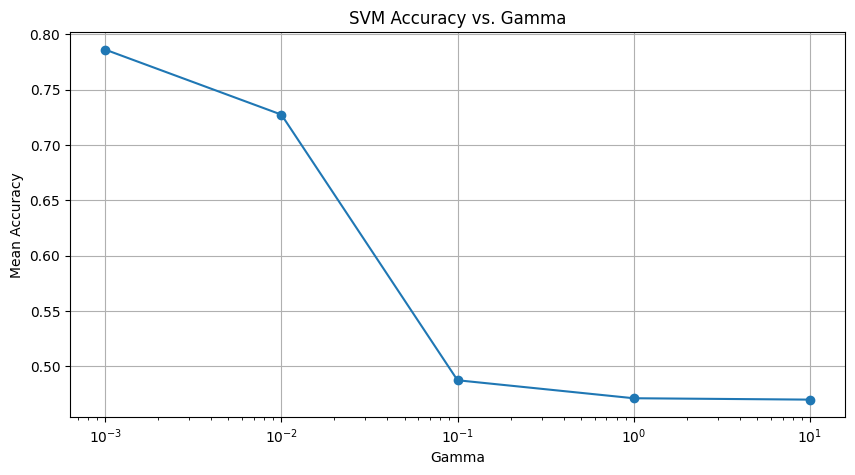

In [20]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying gamma values
gamma_values = [0.001, 0.01, 0.1, 1, 10]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each gamma
mean_accuracies = []

# Loop through each gamma value, train the SVM and calculate cross-validation scores
for gamma in gamma_values:
    svm_classifier = SVC(kernel="rbf", gamma=gamma)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Gamma: {gamma}, Mean Accuracy: {mean_accuracy}")

# You could also plot these to see how gamma affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(gamma_values, mean_accuracies, marker='o')
plt.xlabel('Gamma')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Gamma')
plt.xscale('log')  # Since gamma values vary in orders of magnitude, log scale might be more informative
plt.grid(True)
plt.show()

Degree: 1, Cross-validation scores: [0.76875 0.63125 0.7625  0.7125  0.7375 ]
Degree: 1, Mean Accuracy: 0.7224999999999999
Degree: 2, Cross-validation scores: [0.8     0.71875 0.775   0.725   0.725  ]
Degree: 2, Mean Accuracy: 0.74875
Degree: 3, Cross-validation scores: [0.725  0.625  0.675  0.675  0.6375]
Degree: 3, Mean Accuracy: 0.6675000000000001
Degree: 4, Cross-validation scores: [0.625   0.56875 0.56875 0.63125 0.55   ]
Degree: 4, Mean Accuracy: 0.5887500000000001
Degree: 5, Cross-validation scores: [0.59375 0.54375 0.53125 0.6125  0.55   ]
Degree: 5, Mean Accuracy: 0.5662499999999999


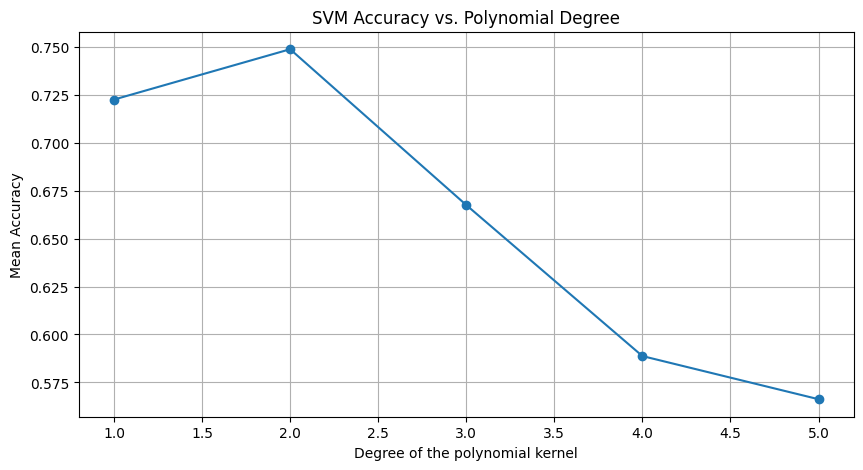

In [21]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
import numpy as np

# Define your SVM classifier with varying degrees
degree_values = [1, 2, 3, 4, 5]  # Different degrees of the polynomial to test
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize an empty list to store mean accuracies for each degree
mean_accuracies = []

# Loop through each degree value, train the SVM and calculate cross-validation scores
for degree in degree_values:
    svm_classifier = SVC(kernel="poly", degree=degree)
    cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)
    mean_accuracy = cv_scores.mean()
    mean_accuracies.append(mean_accuracy)
    print(f"Degree: {degree}, Cross-validation scores: {cv_scores}")
    print(f"Degree: {degree}, Mean Accuracy: {mean_accuracy}")

# Optionally, you could plot these to visualize how the degree affects accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(degree_values, mean_accuracies, marker='o')
plt.xlabel('Degree of the polynomial kernel')
plt.ylabel('Mean Accuracy')
plt.title('SVM Accuracy vs. Polynomial Degree')
plt.grid(True)
plt.show()

In [22]:
# Define your SVM classifier
svm_classifier = SVC(kernel="poly")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.725  0.625  0.675  0.675  0.6375]
Mean Accuracy: 0.6675000000000001


In [23]:
# Define your SVM classifier
svm_classifier = SVC(kernel="sigmoid")

# Train your classifier using k-fold cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the mean accuracy
mean_accuracy = cv_scores.mean()
print("Mean Accuracy:", mean_accuracy)

Cross-validation scores: [0.73125 0.58125 0.73125 0.675   0.675  ]
Mean Accuracy: 0.67875


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_lr = cross_val_score(logistic_regression_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Logistic Regression:", cv_scores_lr)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_lr = cv_scores_lr.mean()
std_dev_accuracy_lr = cv_scores_lr.std()
print("Mean Accuracy with Logistic Regression:", mean_accuracy_lr)
print("Standard Deviation of Accuracy with Logistic Regression:", std_dev_accuracy_lr)

Cross-validation scores with Logistic Regression: [0.725   0.73125 0.73125 0.7375  0.80625]
Mean Accuracy with Logistic Regression: 0.74625
Standard Deviation of Accuracy with Logistic Regression: 0.03025929609227553


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [24]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

# Define the number of neighbors for KNN
num_neighbors = 5

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=num_neighbors)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_knn = cross_val_score(knn_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with KNN:", cv_scores_knn)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_knn = cv_scores_knn.mean()
std_dev_accuracy_knn = cv_scores_knn.std()
print("Mean Accuracy with KNN:", mean_accuracy_knn)
print("Standard Deviation of Accuracy with KNN:", std_dev_accuracy_knn)

Cross-validation scores with KNN: [0.74375 0.675   0.73125 0.69375 0.775  ]
Mean Accuracy with KNN: 0.7237500000000001
Standard Deviation of Accuracy with KNN: 0.03566335654421776


In [25]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier (Gaussian Naive Bayes)
nb_classifier = GaussianNB()

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores_nb = cross_val_score(nb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with Naive Bayes:", cv_scores_nb)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy_nb = cv_scores_nb.mean()
std_dev_accuracy_nb = cv_scores_nb.std()
print("Mean Accuracy with Naive Bayes:", mean_accuracy_nb)
print("Standard Deviation of Accuracy with Naive Bayes:", std_dev_accuracy_nb)

Cross-validation scores with Naive Bayes: [0.61875 0.55625 0.55625 0.64375 0.60625]
Mean Accuracy with Naive Bayes: 0.5962500000000001
Standard Deviation of Accuracy with Naive Bayes: 0.0348209706929603


In [26]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Initialize the k-fold cross-validation generator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(xgb_classifier, X, y_encoded, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores with XGBoost:", cv_scores)

# Calculate and print the mean accuracy and standard deviation of the cross-validation scores
mean_accuracy = cv_scores.mean()
std_dev_accuracy = cv_scores.std()
print("Mean Accuracy with XGBoost:", mean_accuracy)
print("Standard Deviation of Accuracy with XGBoost:", std_dev_accuracy)

Cross-validation scores with XGBoost: [0.83125 0.69375 0.70625 0.7375  0.76875]
Mean Accuracy with XGBoost: 0.7474999999999999
Standard Deviation of Accuracy with XGBoost: 0.04930770730829006
